In [1]:
import io
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
from collections import Counter, defaultdict
import spacy
from sklearn.model_selection import train_test_split
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
from nltk.translate.bleu_score import corpus_bleu
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Input, layers
from keras.activations import softmax
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

Using TensorFlow backend.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

In [3]:
data_path = '../data'
model_path = '../model'

In [4]:
# Translation data
# http://www.manythings.org/anki/
with io.open(os.path.join(data_path, 'fra-eng/fra.txt'), encoding='utf-8') as f:
    lines = f.read().split('\n')

pairs = [l.split('\t') for l in lines if l != '']
pairs = [[re.sub(u"\u202f|\u2009", " ", s) for s in p] for p in pairs]
pairs = [[re.sub(u"\u2019", "'", s) for s in p] for p in pairs]

In [5]:
X, y = np.array(pairs)[:, 0], np.array(pairs)[:, 1]
len(X), len(y)

(154883, 154883)

In [6]:
zip(X, y)[:5]

[(u'Go.', u'Va !'),
 (u'Run!', u'Cours !'),
 (u'Run!', u'Courez !'),
 (u'Fire!', u'Au feu !'),
 (u'Help!', u"\xc0 l'aide !")]

# Extract features

In [7]:
# Tokenize
spacy_tokenizer_en = spacy.load('en', disable=['tagger', 'parser', 'ner', 'textcat'])
spacy_tokenizer_fr = spacy.load('fr', disable=['tagger', 'parser', 'ner', 'textcat'])

In [8]:
def tokenize(msgs, tokenizer, batch_size=10000, n_threads=num_cores):
    msgs = [unicode(msg.lower()) for msg in msgs]
    toks = []
    for msg in tokenizer.pipe(msgs, batch_size=batch_size, n_threads=n_threads):
        toks.append([tok.text for tok in msg])
    return toks

In [9]:
# Tokenize source sentences
X = tokenize(X, spacy_tokenizer_en)
len(X)

154883

In [10]:
# Tokenize target sentences
y = tokenize(y, spacy_tokenizer_fr)
len(y)

154883

In [11]:
zip(X, y)[:5]

[([u'go', u'.'], [u'va', u'!']),
 ([u'run', u'!'], [u'cours', u'!']),
 ([u'run', u'!'], [u'courez', u'!']),
 ([u'fire', u'!'], [u'au', u'feu', u'!']),
 ([u'help', u'!'], [u'\xe0', u"l'", u'aide', u'!'])]

In [12]:
# For ease of training, only keep sentences shorter than 20 words
X_len = [len(msg) for msg in X]
y_len = [len(msg) for msg in y]

min_len = 2
max_len = 20

X_to_keep_ix = np.where((np.array(X_len) >= min_len) & (np.array(X_len) <= max_len))[0]
y_to_keep_ix = np.where((np.array(y_len) >= min_len) & (np.array(y_len) <= max_len))[0]

to_keep_ix = np.intersect1d(X_to_keep_ix, y_to_keep_ix)
len(to_keep_ix)

154165

In [13]:
X = np.array(X)[to_keep_ix]
y = np.array(y)[to_keep_ix]

len(X), len(y)

(154165, 154165)

In [14]:
# Split into training and validation sets
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=0)
len(X_trn), len(X_val), len(y_trn), len(y_val)

(123332, 30833, 123332, 30833)

In [15]:
# Create mappers (using training data)
X_toks_trn = list(itertools.chain(*X_trn))
y_toks_trn = list(itertools.chain(*y_trn))

len(X_toks_trn), len(y_toks_trn)

(926993, 1025792)

In [16]:
UNK = '_unk_'
PAD = '_pad_'

def create_mapper(toks, max_vocab=100000, min_freq=1, UNK=UNK, PAD=PAD):
    """Create mappers between tokens and numerical indices.

    Parameters
    ----------
    toks : A list containing all raw tokens (before deduping).

    max_vocab : The maximum vocabulary size.

    min_freq : The minimum frequency for a token to be included in the vocabulary.

    UNK : Special token for unknown word (default to '_unk_').

    PAD : Special token for paddings (default to '_pad_').

    Returns
    -------
    stoi : A dictionary that maps tokens to indices.

    itos : A list that maps indices to tokens.
    """
    
    toks_freq = Counter(toks)
    
    itos = [s for s, c in toks_freq.most_common(max_vocab) if c >= min_freq]
    
    if PAD:
        if UNK:
            itos.insert(0, UNK)
            itos.insert(0, PAD)  # Note the index for UNK is 1 and the index for PAD is 0

            stoi = defaultdict(lambda: 1, {v: k for k, v in enumerate(itos)})
        else:
            itos.insert(0, PAD)  # Note the index for PAD is 0
            stoi = {v: k for k, v in enumerate(itos)}
    else:
        if UNK:
            itos.insert(0, UNK)  # Note the index for UNK is 0
            stoi = defaultdict(lambda: 0, {v: k for k, v in enumerate(itos)})
        else:
            stoi = {v: k for k, v in enumerate(itos)}
    
    return stoi, itos

In [17]:
X_stoi, X_itos = create_mapper(X_toks_trn)
y_stoi, y_itos = create_mapper(y_toks_trn)

len(X_itos), len(y_itos)

(12633, 21654)

In [18]:
X_itos[:10]

['_pad_', '_unk_', u'.', u'i', u'you', u'to', u'the', u'?', u'a', u"n't"]

In [19]:
y_itos[:10]

['_pad_', '_unk_', u'.', u'je', u'de', u'?', u'pas', u'vous', u'est', u'que']

In [20]:
# Add GO (only needed for the target mappers)
GO = '_go_'

y_stoi[GO] = len(y_stoi)
y_itos.append(GO)

In [21]:
# Encode text features
def encode_msg(toks, stoi, max_len, padding_pos='post', truncating='pre', padding_token=PAD):
    # Index
    toks_id = [[stoi[tok] for tok in msg] for msg in toks]
    
    # Pad
    toks_id_pad = pad_sequences(toks_id, max_len, padding=padding_pos, truncating=truncating, value=stoi[padding_token])
    
    return toks_id_pad

In [22]:
X_ix_trn = encode_msg(X_trn, X_stoi, max_len)
y_ix_trn = encode_msg(y_trn, y_stoi, max_len)
X_ix_val = encode_msg(X_val, X_stoi, max_len)
y_ix_val = encode_msg(y_val, y_stoi, max_len)

X_ix_trn.shape, y_ix_trn.shape, X_ix_val.shape, y_ix_val.shape

((123332, 20), (123332, 20), (30833, 20), (30833, 20))

In [23]:
# Sanity check
np.array(X_itos)[X_ix_trn[0]], np.array(y_itos)[y_ix_trn[0]]

(array([u'delivery', u'is', u'not', u'included', u'in', u'the', u'price',
        u'.', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_'],
       dtype='<U17'),
 array([u'la', u'livraison', u"n'", u'est', u'pas', u'comprise', u'dans',
        u'le', u'prix', u'.', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_'],
       dtype='<U22'))

In [24]:
np.array(X_itos)[X_ix_val[0]], np.array(y_itos)[y_ix_val[0]]

(array([u'i', u'just', u'do', u"n't", u'want', u'you', u'making', u'any',
        u'mistakes', u'.', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_'],
       dtype='<U17'),
 array([u'je', u'ne', u'veux', u'tout', u'simplement', u'pas', u'que',
        u'tu', u'commettes', u"d'", u'erreurs', u'.', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_'],
       dtype='<U22'))

In [25]:
# Save processed data
data = {
    # Mappers
    'X_stoi': X_stoi,
    'X_itos': X_itos,
    'y_stoi': y_stoi,
    'y_itos': y_itos,
    
    # Original data
    'X_trn': X_trn,
    'X_val': X_val,
    'y_trn': y_trn,
    'y_val': y_val,
    
    # Processed data
    'X_ix_trn': X_ix_trn,
    'y_ix_trn': y_ix_trn,
    'X_ix_val': X_ix_val,
    'y_ix_val': y_ix_val
}

pickle.dump(data, open(os.path.join(data_path, 'translate-data.pkl'), 'wb'))

In [4]:
# Load processed data (in a new session)
data = pickle.load(open(os.path.join(data_path, 'translate-data.pkl'), 'rb'))

X_stoi, X_itos, y_stoi, y_itos = data['X_stoi'], data['X_itos'], data['y_stoi'], data['y_itos']
X_trn, X_val, y_trn, y_val = data['X_trn'], data['X_val'], data['y_trn'], data['y_val']
X_ix_trn, X_ix_val, y_ix_trn, y_ix_val = data['X_ix_trn'], data['X_ix_val'], data['y_ix_trn'], data['y_ix_val']

max_len = 20

UNK = '_unk_'
PAD = '_pad_'
GO = '_go_'

# Create models

In [34]:
K.clear_session()

## Encoder

In [35]:
# Define hidden size
hidden_size_enc = 256
hidden_size_dec = 256

In [36]:
# Define layers
txt_embed_size = 300

X_embed_layer = layers.Embedding(input_dim=len(X_itos), output_dim=txt_embed_size, name='X_embed_layer')
lstm_enc = layers.LSTM(hidden_size_enc, return_sequences=True, return_state=True, name='lstm_enc')

In [37]:
# Input tensor
X = Input(shape=(max_len, ), name='X')

In [38]:
# Encode
def encode(X):
    X_emb = X_embed_layer(X)
    a_enc, h_enc, c_enc = lstm_enc(X_emb)
    return a_enc, h_enc, c_enc

## Decoder without attention

### Decoder

In [32]:
# Define layers
y_embed_layer = layers.Embedding(input_dim=len(y_itos), output_dim=txt_embed_size, name='y_embed_layer')
lstm_dec_wo_attn = layers.LSTM(hidden_size_dec, return_sequences=True, return_state=True, name='lstm_dec_wo_attn')
densor_dec = layers.Dense(len(y_itos), activation='softmax', name='densor_dec')

In [33]:
# Decoder input used in training (i.e., "GO" + `y` shifted by 1)
in_dec = Input(shape=(max_len, ), name='in_dec')

In [34]:
def decode_wo_attn(in_dec, h_enc, c_enc):
    in_dec_emb = y_embed_layer(in_dec)
    
    # Feed into decoder LSTM
    a_dec, h_dec, c_dec = lstm_dec_wo_attn(in_dec_emb, initial_state=[h_enc, c_enc])
    
    # Feed the output into a dense layer with softmax
    out_dec = densor_dec(a_dec)
    return out_dec, h_dec, c_dec

### Put together

In [35]:
# Encode
a_enc, h_enc, c_enc = encode(X)

In [36]:
# Decode
out_dec, _, _ = decode_wo_attn(in_dec, h_enc, c_enc)

In [37]:
# Put together
model_wo_attn = Model(inputs=[X, in_dec], outputs=out_dec)
model_wo_attn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 20)           0                                            
__________________________________________________________________________________________________
in_dec (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
X_embed_layer (Embedding)       (None, 20, 300)      3789900     X[0][0]                          
__________________________________________________________________________________________________
y_embed_layer (Embedding)       (None, 20, 300)      6496500     in_dec[0][0]                     
__________________________________________________________________________________________________
lstm_enc (

In [38]:
model_wo_attn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

## Decoder with attention

### Attention layer

In [39]:
# Define layers
attn_repeator = layers.RepeatVector(max_len, name='attn_repeator')
attn_concatenator = layers.Concatenate(name='attn_concatenator')
attn_weights_computer = layers.Dense(1, activation='tanh', name='attn_weights_computer')

def softmax_axis_1(x):
    return softmax(x, axis=1)
attn_weights_normalizer = layers.Activation(softmax_axis_1, name='attn_weights_normalizer')

attn_context_computer = layers.Dot(axes=1, name='attn_context_computer')

In [40]:
def one_step_attn(a_enc, h_dec_prev):
    # Repeat `h_dec_prev`
    h_dec_prev_rep = attn_repeator(h_dec_prev)  # (None, timesteps, hidden_size_dec)
    
    # Compute the attention weights
    h_dec_prev_w_a_enc = attn_concatenator([h_dec_prev_rep, a_enc])  # (None, timesteps, hidden_size_dec + hidden_size_enc)
    attn_weights = attn_weights_computer(h_dec_prev_w_a_enc)  # (None, timesteps, 1)
    
    # Normalize all the weights using a softmax (the normalization is applied in the timestep's axis)
    attn_weights_norm = attn_weights_normalizer(attn_weights)  # (None, timesteps, 1)
    
    # Use the normalized weights to compute the weighted-average encoder outputs (i.e., the context)
    attn_context = attn_context_computer([attn_weights_norm, a_enc])  # (None, 1, hidden_size_dec)
    
    return attn_context, attn_weights_norm

### Decoder

In [41]:
y_embed_layer = layers.Embedding(input_dim=len(y_itos), output_dim=txt_embed_size, name='y_embed_layer')
context_input_concatenator = layers.Concatenate(name='context_input_concatenator')
densor_dec_0 = layers.Dense(hidden_size_dec, name='densor_dec_0')
lstm_dec_w_attn = layers.LSTM(hidden_size_dec, return_sequences=False, return_state=True, name='lstm_dec_w_attn')
densor_dec_1 = layers.Dense(len(y_itos), activation='softmax', name='densor_dec_1')

In [42]:
# One-step decoder
def decode_w_attn(in_dec, a_enc, h_dec_prev, c_dec_prev):
    # Compute context vector using the attention layer
    attn_context, attn_weights_norm = one_step_attn(a_enc, h_dec_prev)
    
    # Concatenate with the decoder input
    in_dec_embed = y_embed_layer(in_dec)
    attn_context_w_input = context_input_concatenator([attn_context, in_dec_embed])
    
    # Reduce dimension to the original hidden size
    attn_context_w_input = densor_dec_0(attn_context_w_input)
    
    # Feed into decoder LSTM
    a_dec, h_dec, c_dec = lstm_dec_w_attn(attn_context_w_input, initial_state=[h_dec_prev, c_dec_prev])
    
    # Feed the output into a dense layer with softmax
    out_dec = densor_dec_1(a_dec)
    return out_dec, h_dec, c_dec, attn_weights_norm

###  Put together

In [43]:
# Encode
a_enc, h_enc, c_enc = encode(X)

In [44]:
# Decode
in_dec_0 = Input(shape=(1, ), name='in_dec_0')  # Decoder starting token ("_go_")
y = Input(shape=(max_len, ), name='y')
y_slicer = layers.Lambda(lambda x: x[:, i:i+1], name='y_slicer')

h_dec_prev, c_dec_prev = h_enc, c_enc
in_dec = in_dec_0
outs_dec = []

for i in range(max_len):
    out_dec, h_dec, c_dec, _ = decode_w_attn(in_dec, a_enc, h_dec_prev, c_dec_prev)
    outs_dec.append(out_dec)
    h_dec_prev, c_dec_prev = h_dec, c_dec
    in_dec = y_slicer(y)

In [45]:
# Put together
model_w_attn = Model(inputs=[X, in_dec_0, y], outputs=outs_dec)
model_w_attn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 20)           0                                            
__________________________________________________________________________________________________
X_embed_layer (Embedding)       (None, 20, 300)      3789900     X[0][0]                          
__________________________________________________________________________________________________
lstm_enc (LSTM)                 [(None, 20, 256), (N 570368      X_embed_layer[0][0]              
__________________________________________________________________________________________________
attn_repeator (RepeatVector)    (None, 20, 256)      0           lstm_enc[0][1]                   
                                                                 lstm_dec_w_attn[0][1]            
          

In [46]:
model_w_attn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Train models

## Model without attention

In [39]:
# Initialize decoder input
in_dec_trn = np.hstack([np.array([y_stoi[GO]] * len(X_ix_trn)).reshape(-1, 1), y_ix_trn[:, :-1]])
in_dec_val = np.hstack([np.array([y_stoi[GO]] * len(X_ix_val)).reshape(-1, 1), y_ix_val[:, :-1]])

in_dec_trn.shape, in_dec_val.shape

((123332, 20), (30833, 20))

In [40]:
# Reshape outputs in order to use `sparse_categorical_crossentropy`
y_ix_trn_rs = y_ix_trn.reshape(y_ix_trn.shape[0], y_ix_trn.shape[1], 1)
y_ix_val_rs = y_ix_val.reshape(y_ix_val.shape[0], y_ix_val.shape[1], 1)

y_ix_trn_rs.shape, y_ix_val_rs.shape

((123332, 20, 1), (30833, 20, 1))

In [41]:
# Add callbacks
callbacks = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks.append(reduce_lr)

stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(stopper)

checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, 'translate-keras-wo_attn.h5'), monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

In [ ]:
# Train
hist_wo_attn = model_wo_attn.fit(
    x=[X_ix_trn, in_dec_trn],
    y=y_ix_trn_rs,
    batch_size=64,
    epochs=20,
    validation_data=([X_ix_val, in_dec_val], y_ix_val_rs),
    callbacks=callbacks)

In [52]:
def plot_losses(model_hist):
    loss = pd.DataFrame(zip(model_hist.history['loss'], model_hist.history['val_loss']), columns=['loss', 'val_loss'])
    
    # Find the epoch with the smallest loss
    min_loss_ix = np.array(model_hist.history['val_loss']).argmin()

    # Plot
    ax = loss.plot()
    ax.axvline(x=min_loss_ix, color='black', ls='--')

    return loss

,loss,val_loss
0,2.094947,1.519535
1,1.252428,1.110582
2,0.917041,0.909936
3,0.708736,0.798361
4,0.566654,0.739701
5,0.464769,0.703792
6,0.389168,0.685777
7,0.331917,0.679685
8,0.288845,0.679521
9,0.254722,0.681743


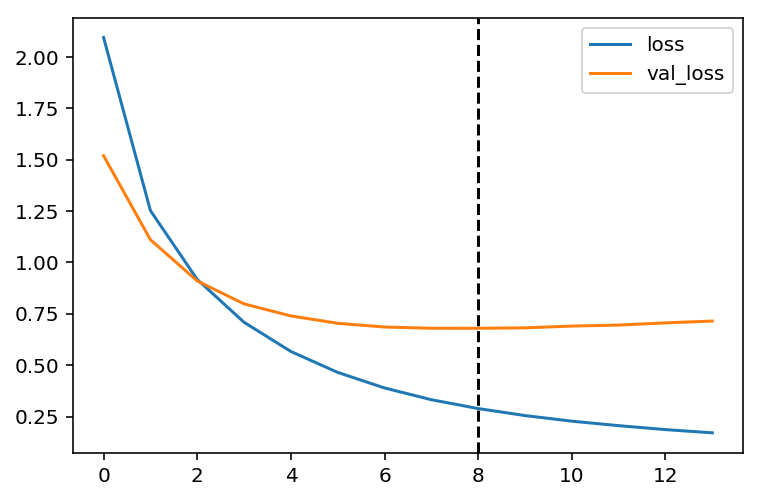

In [44]:
plot_losses(hist_wo_attn)

## Model with attention

In [47]:
# Initialize decoder input ("_go_")
in_dec_0_trn = np.array([y_stoi[GO]] * len(X_ix_trn)).reshape(-1, 1)
in_dec_0_val = np.array([y_stoi[GO]] * len(X_ix_val)).reshape(-1, 1)

in_dec_0_trn.shape, in_dec_0_val.shape

((123332, 1), (30833, 1))

In [48]:
# Reshape outputs in order to use `sparse_categorical_crossentropy`
y_ix_trn_rs = [y_ix_trn[:, i:i+1] for i in range(y_ix_trn.shape[1])]
y_ix_val_rs = [y_ix_val[:, i:i+1] for i in range(y_ix_val.shape[1])]

np.array(y_ix_trn_rs).shape, np.array(y_ix_val_rs).shape

((20, 123332, 1), (20, 30833, 1))

In [49]:
# Add callbacks
callbacks = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks.append(reduce_lr)

stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(stopper)

checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, 'translate-keras-w_attn.h5'), monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

In [ ]:
# Train
hist_w_attn = model_w_attn.fit(
    x=[X_ix_trn, in_dec_0_trn, y_ix_trn],
    y=y_ix_trn_rs,
    batch_size=64,
    epochs=20,
    validation_data=([X_ix_val, in_dec_0_val, y_ix_val], y_ix_val_rs),
    callbacks=callbacks)

,loss,val_loss
0,43.821551,31.839506
1,27.663818,25.676821
2,22.039359,21.794184
3,17.805494,18.948141
4,14.573832,17.109187
5,12.122532,15.964509
6,10.270382,15.220972
7,8.848394,14.809435
8,7.753536,14.533260
9,6.894239,14.392262


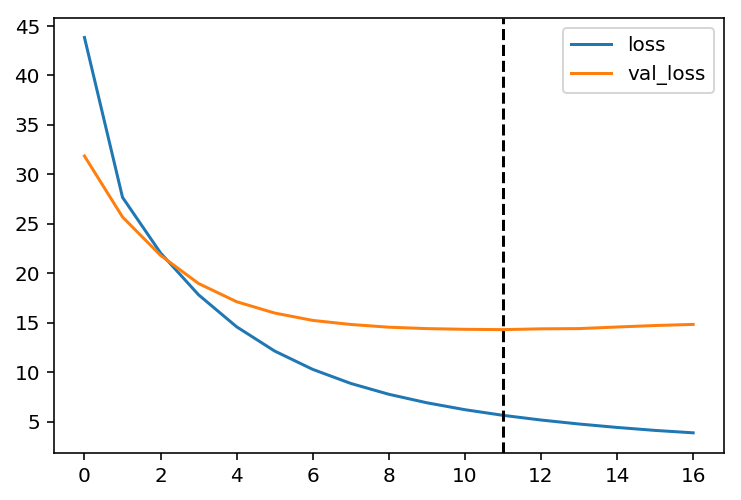

In [53]:
plot_losses(hist_w_attn)

# Inference

## Model without attention

In [45]:
# Reload the last checkpoint
model_wo_attn = load_model(os.path.join(model_path, 'translate-keras-wo_attn.h5'))

In [46]:
# Extract encoder
X = Input(shape=(max_len, ), name='X')
X_embed_layer = model_wo_attn.get_layer('X_embed_layer')
lstm_enc = model_wo_attn.get_layer('lstm_enc')

encoder = Model(X, encode(X))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 20)                0         
_________________________________________________________________
X_embed_layer (Embedding)    (None, 20, 300)           3789900   
_________________________________________________________________
lstm_enc (LSTM)              [(None, 20, 256), (None,  570368    
Total params: 4,360,268
Trainable params: 4,360,268
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Extract decoder
in_dec = Input(shape=(1, ), name='in_dec')
h_dec_prev = Input(shape=(hidden_size_dec, ), name='h_dec_prev')
c_dec_prev = Input(shape=(hidden_size_dec, ), name='c_dec_prev')
y_embed_layer = model_wo_attn.get_layer('y_embed_layer')
lstm_dec_wo_attn = model_wo_attn.get_layer('lstm_dec_wo_attn')
densor_dec = model_wo_attn.get_layer('densor_dec')

decoder = Model([in_dec, h_dec_prev, c_dec_prev], decode_wo_attn(in_dec, h_dec_prev, c_dec_prev))
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_dec (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
y_embed_layer (Embedding)       multiple             6496500     in_dec[0][0]                     
__________________________________________________________________________________________________
h_dec_prev (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
c_dec_prev (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_dec_w

In [54]:
def decode_sequence(input_seqs, encoder, decoder, toks_stoi, toks_itos, max_len, w_attn=False, return_attn_weights=False):
    # Generate encoder output
    a_enc_pred, h_enc_pred, c_enc_pred = encoder.predict(input_seqs)

    # Generate decoder output, one timestep at a time
    outs_dec_pred = []
    attn_weights = []
    in_dec = np.array([toks_stoi[GO]] * len(input_seqs)).reshape(-1, 1)
    h_dec_pred = h_enc_pred
    c_dec_pred = c_enc_pred

    for i in range(max_len):
        if not w_attn:
            out_dec_pred, h_dec_pred, c_dec_pred = decoder.predict([in_dec, h_dec_pred, c_dec_pred])
        else:
            out_dec_pred, h_dec_pred, c_dec_pred, attn_weight = decoder.predict([in_dec, a_enc_pred, h_dec_pred, c_dec_pred])

        # Derive the predicted token
        # Need to first reduce the dimension of `out_dec_pred` from 3D to 2D
        # (It's 3D because there is a `timestep` of 1 in the middle)
        out_dec_pred = out_dec_pred.reshape(out_dec_pred.shape[0], out_dec_pred.shape[-1])
        out_dec_pred = out_dec_pred.argmax(axis=-1)
        outs_dec_pred.append(out_dec_pred)

        # Assign the predicted token as the next decoder input
        in_dec = out_dec_pred
        
        # Save attention weights
        if w_attn:
            attn_weights.append(attn_weight.reshape(attn_weight.shape[0], attn_weight.shape[1]))

    # Convert output index into tokens
    outs_dec_pred = np.array(toks_itos)[np.array(outs_dec_pred).transpose()]
    
    # Clean up and output
    outs_dec_pred = [detok(toks) for toks in outs_dec_pred]
    if not return_attn_weights:
        return outs_dec_pred
    return outs_dec_pred, attn_weights

# Convert to strings and clean up
# detokenizer = Detok()

def detok(toks):
    # Cut before the first padding (if any)
    toks = list(toks)
    if PAD in toks:
        first_pad = toks.index(PAD)
        toks = toks[:first_pad]
    
    # return detokenizer.detokenize(toks)
    return ' '.join(toks)

In [49]:
# Test inference with validation data
y_val_pred_wo_attn = decode_sequence(X_ix_val, encoder, decoder, y_stoi, y_itos, max_len)
len(y_val_pred_wo_attn)

30833

In [50]:
# Print out a few results
for i in range(5):
    print(i)
    print('Input:\t\t' + detok(X_val[i]))
    print('Predicted:\t' + y_val_pred_wo_attn[i])
    print('True:\t\t' + detok(y_val[i]))

0
Input:		i just do n't want you making any mistakes .
Predicted:	je ne veux que vous commettiez d' erreurs , vous n' importe pas .
True:		je ne veux tout simplement pas que tu commettes d' erreurs .
1
Input:		i thought i 'd find you here .
Predicted:	je pensais que je vous trouverais ici .
True:		je pensais que je te trouverais ici .
2
Input:		what do you like to eat for lunch ?
Predicted:	qu' aimes - tu manger pour dîner ?
True:		qu' aimes - tu manger au déjeuner ?
3
Input:		elephants are an endangered species .
Predicted:	les éléphants en ont une menace pour la santé .
True:		les éléphants sont une espèce menacée .
4
Input:		accidents often result from carelessness .
Predicted:	les accidents d' accidents d' accidents .
True:		les accidents proviennent souvent d' un manque d' attention .


In [51]:
# Save predictions
pickle.dump(y_val_pred_wo_attn, open(os.path.join(data_path, 'translate-pred_wo_attn.pkl'), 'wb'))

## Model with attention

In [55]:
# Reload the last checkpoint
model_w_attn = load_model(os.path.join(model_path, 'translate-keras-w_attn.h5'), custom_objects={'softmax_axis_1': softmax_axis_1, 'i': 0})

In [56]:
# Extract encoder
X = Input(shape=(max_len, ), name='X')
X_embed_layer = model_w_attn.get_layer('X_embed_layer')
lstm_enc = model_w_attn.get_layer('lstm_enc')

encoder = Model(X, encode(X))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 20)                0         
_________________________________________________________________
X_embed_layer (Embedding)    (None, 20, 300)           3789900   
_________________________________________________________________
lstm_enc (LSTM)              [(None, 20, 256), (None,  570368    
Total params: 4,360,268
Trainable params: 4,360,268
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Extract decoder
in_dec = Input(shape=(1, ), name='in_dec')
a_enc = Input(shape=(max_len, hidden_size_enc), name='a_enc')
h_dec_prev = Input(shape=(hidden_size_dec, ), name='h_dec_prev')
c_dec_prev = Input(shape=(hidden_size_dec, ), name='c_dec_prev')

y_embed_layer = model_w_attn.get_layer('y_embed_layer')
attn_repeator = model_w_attn.get_layer('attn_repeator')
attn_concatenator = model_w_attn.get_layer('attn_concatenator')
attn_weights_computer = model_w_attn.get_layer('attn_weights_computer')
attn_weights_normalizer = model_w_attn.get_layer('attn_weights_normalizer')
attn_context_computer = model_w_attn.get_layer('attn_context_computer')
context_input_concatenator = model_w_attn.get_layer('context_input_concatenator')
densor_dec_0 = model_w_attn.get_layer('densor_dec_0')
lstm_dec_w_attn = model_w_attn.get_layer('lstm_dec_w_attn')
densor_dec_1 = model_w_attn.get_layer('densor_dec_1')

decoder = Model([in_dec, a_enc, h_dec_prev, c_dec_prev], decode_w_attn(in_dec, a_enc, h_dec_prev, c_dec_prev))
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
h_dec_prev (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
attn_repeator (RepeatVector)    (None, 20, 256)      0           h_dec_prev[0][0]                 
__________________________________________________________________________________________________
a_enc (InputLayer)              (None, 20, 256)      0                                            
__________________________________________________________________________________________________
attn_concatenator (Concatenate) (None, 20, 512)      0           attn_repeator[20][0]             
                                                                 a_enc[0][0]                      
__________

In [61]:
# Test inference with validation data
y_val_pred_w_attn, y_val_attn_weights = decode_sequence(X_ix_val, encoder, decoder, y_stoi, y_itos, max_len, w_attn=True, return_attn_weights=True)
len(y_val_pred_w_attn)

30833

In [62]:
# Print out a few results
for i in range(5):
    print(i)
    print('Input:\t\t' + detok(X_val[i]))
    print('Predicted:\t' + y_val_pred_w_attn[i])
    print('True:\t\t' + detok(y_val[i]))

0
Input:		i just do n't want you making any mistakes .
Predicted:	je ne veux tout simplement pas que vous commettiez d' erreurs .
True:		je ne veux tout simplement pas que tu commettes d' erreurs .
1
Input:		i thought i 'd find you here .
Predicted:	je pensais que je vous trouver ici .
True:		je pensais que je te trouverais ici .
2
Input:		what do you like to eat for lunch ?
Predicted:	qu' as - tu envie de manger le déjeuner ?
True:		qu' aimes - tu manger au déjeuner ?
3
Input:		elephants are an endangered species .
Predicted:	les éléphants sont en amérique pour la justice .
True:		les éléphants sont une espèce menacée .
4
Input:		accidents often result from carelessness .
Predicted:	les accidents de tous les adolescents .
True:		les accidents proviennent souvent d' un manque d' attention .


In [63]:
# Save predictions
pickle.dump(y_val_pred_w_attn, open(os.path.join(data_path, 'translate-pred_w_attn.pkl'), 'wb'))
pickle.dump(y_val_attn_weights, open(os.path.join(data_path, 'translate-attn_weights_w_attn.pkl'), 'wb'))

In [66]:
# Combine the two models' predictions
y_val_pred_wo_attn = pickle.load(open(os.path.join(data_path, 'translate-pred_wo_attn.pkl'), 'rb'))
y_val_pred_w_attn = pickle.load(open(os.path.join(data_path, 'translate-pred_w_attn.pkl'), 'rb'))

y_val_true_vs_pred = pd.DataFrame({
    'source': [' '.join(s) for s in X_val],
    'true_target': [' '.join(s) for s in y_val],
    'pred_wo_attn': y_val_pred_wo_attn,
    'pred_w_attn': y_val_pred_w_attn
})
y_val_true_vs_pred.shape

(30833, 4)

In [67]:
# Sample 20 to review
y_val_true_vs_pred_samp = y_val_true_vs_pred.sample(20, random_state=0)
y_val_true_vs_pred_samp = y_val_true_vs_pred_samp[['source', 'true_target', 'pred_wo_attn', 'pred_w_attn']]
y_val_true_vs_pred_samp.head()

,source,true_target,pred_wo_attn,pred_w_attn
28455,whatever happened to your pride ?,qu' est - il advenu de votre fierté ?,qu' est - il advenu de ta fierté ?,qu' est -ce qui a eu à ta petite monnaie ?
231,i feel kind of tired .,je me sens comme fatigué .,je me sens assez fatigué .,je me sens assez fatiguée .
15495,i think that 's tom over there .,je pense que c' est tom là-bas .,je pense que c' est tom là-bas .,je pense que c' est là que tom est en train de...
1897,tom did n't talk about it .,tom n' en a pas parlé .,tom n' en a pas parlé .,tom ne s' en parla .
14637,i just want to be clear .,"je veux être claire , un point c' est tout .",je veux juste être clair .,je veux simplement être claire .


In [68]:
# Output
y_val_true_vs_pred_samp.to_csv(os.path.join(data_path, 'translate-true_vs_pred_samp.csv'), index=False, encoding='utf-8')

## Compute BLEU scores

In [69]:
# Compute corpus-level BLEU score
def compute_corpus_bleu(references, candidates):
    # BLEU-1
    bleu_1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
    
    # BLEU-2
    bleu_2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
    
    # BLEU-3
    bleu_3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))
    
    # BLEU-4
    bleu_4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_1, bleu_2, bleu_3, bleu_4

In [53]:
# Without attention
compute_corpus_bleu([[detok(ref)] for ref in y_val], y_val_pred_wo_attn)

(0.817444026310971, 0.7339931030646256, 0.6719394020014025, 0.6213758007248943)

In [70]:
# With attention
compute_corpus_bleu([[detok(ref)] for ref in y_val], y_val_pred_w_attn)

(0.8049435712192081,
 0.7204637530221997,
 0.6583795576380514,
 0.6083450791367733)

## Visualize attention weights

In [71]:
def visualize_attn_weights(input_seq, output_seq, attn_weights, ax):
    # Remove paddings from the attention weights
    attn_weights = attn_weights[:len(output_seq), :len(input_seq)]
    
    # Convert into a dataframe
    attn_weights = pd.DataFrame(attn_weights, index=output_seq, columns=input_seq)
    
    # Visualize as a heatmap
    fig = sns.heatmap(attn_weights[::-1], cmap='bone', ax=ax)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    fig.set_yticklabels(fig.get_yticklabels(), rotation=0)
    return fig

In [72]:
# For visualization purposes, select the predictions that match the truths perfectly
ix = np.where([true == pred.split() for true, pred in zip(y_val, y_val_pred_w_attn)])[0]
len(ix)

2808

In [73]:
# Sample a few of them to visualize
np.random.seed(0)
ix_samp = np.random.choice(ix, 9, replace=False)

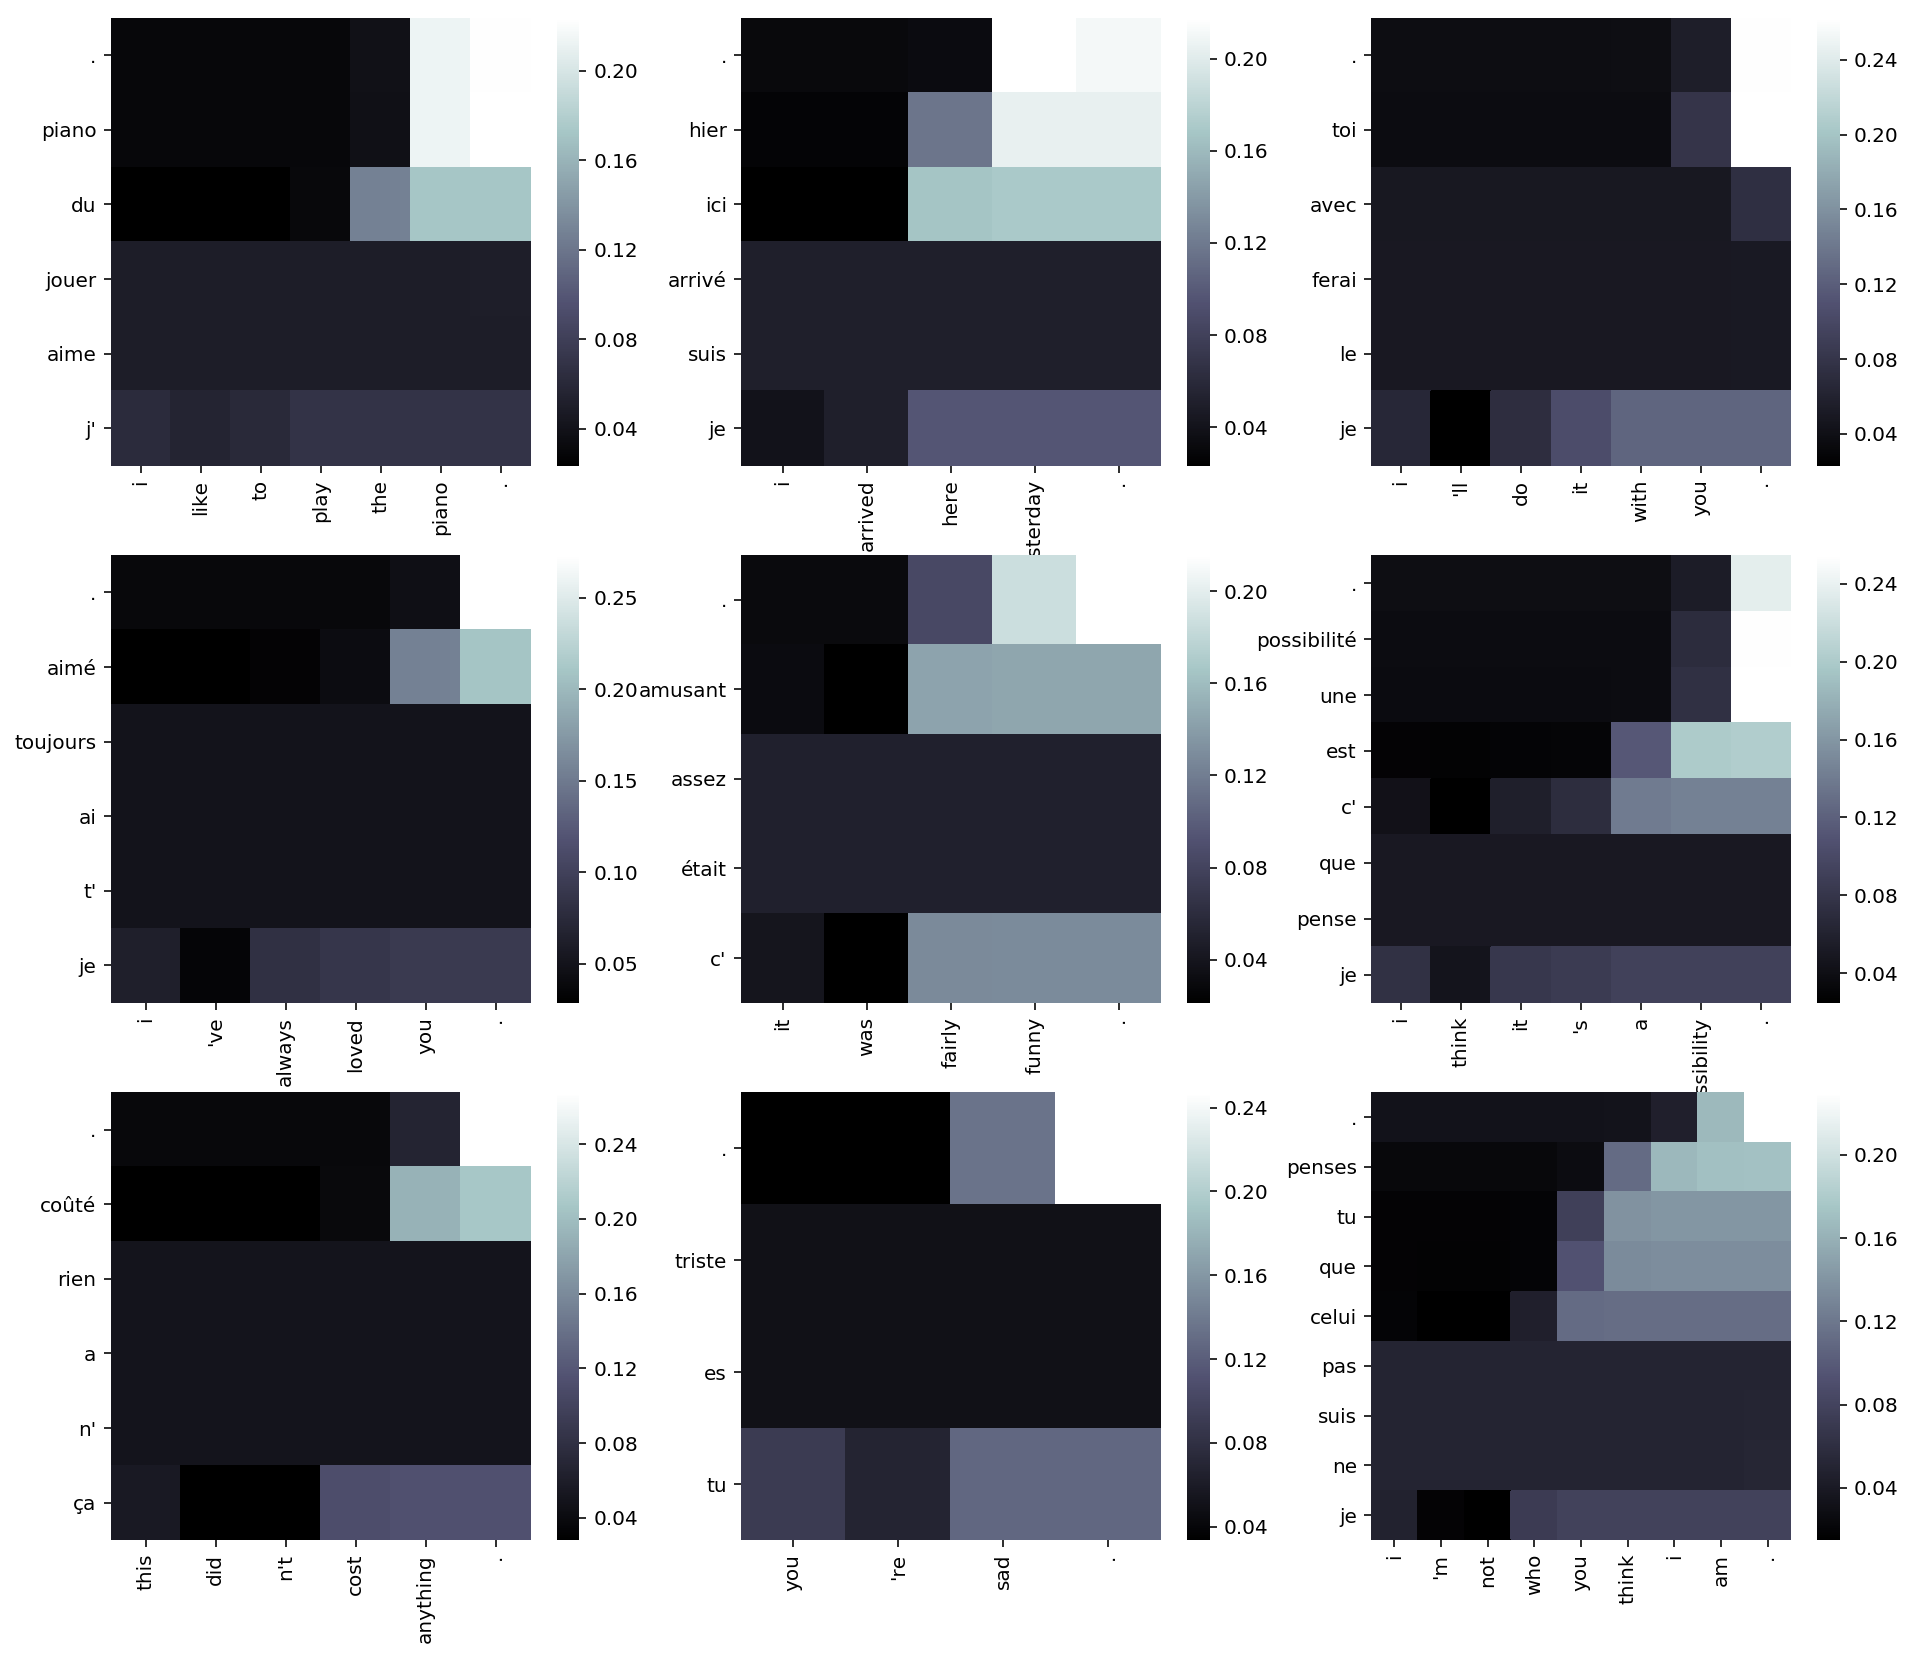

In [74]:
# Visualize
fig, axes = plt.subplots(3, 3, figsize=(16, 14))

for i, ax in enumerate(np.ravel(axes)):
    input_seq = X_val[ix_samp[i]]
    output_seq = y_val_pred_w_attn[ix_samp[i]].split()
    attn_weights = np.array([a[ix_samp[i]] for a in y_val_attn_weights])
    visualize_attn_weights(input_seq, output_seq, attn_weights, ax)